# 1. Generate task sets

There is already a group of task sets in the 'tasksets/' folder in this directory. Run the cell in this section only to generate a new group of task sets.

In [1]:
# import taskset generator algorithm from .py file
from TasksetGenerator import TasksetGenerator

# 2. Run algorithms

In [2]:
# import algorithms from .py files
from System import System
from Task import Task

# 3. Results

## 1) Generate Task Sets

In [3]:
# 1. Task Set Parameters
sys_utils = [0.5, 0.6, 0.7, 0.8, 0.9]
num_sets = 5  # no. task sets to generate with this configuration
n = 200  # no. tasks in set
frame_duration = 200  # length of frame, in ms

precision_dp = 2  # how many decimal places, i.e. 0.01
time_step = 1 / 10**precision_dp  #0.01
lp_hp_ratio = 0.8  # ratio of LP core:HP core speeds

In [4]:
# 1. Generate tasksets for system utilisation 50%, 60%, 70%, 80%, 90%
for sys_util in sys_utils:
    for i in range(num_sets):
        taskset_gen = TasksetGenerator(n, frame_duration, sys_util, precision_dp, lp_hp_ratio)
        taskset_gen.generate('tasksets/sysutil{0}_{1}.csv'.format(sys_util, i))

## 2) Run Simulations

In [5]:
# import CSV reader libraries
from csv import reader
from ast import literal_eval

# no. times to run for average
repeat = 5

# import matplotlib for graph plotting
import matplotlib.pyplot as plt

### a. Energy Consumption vs System Utilisation (%)

In [6]:
# scheduler parameters
k = 20

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations

# 2. Run algorithms
for sys_util in sys_utils:
    energy_consumed_per_sysutil = 0
    for i in range(num_sets):
        # i. import task set
        with open('tasksets/sysutil{0}_{1}.csv'.format(sys_util, i)) as read_obj:
            # pass the file object to reader() to get the reader object
            csv_reader = reader(read_obj)
            # Get all rows of csv from csv_reader object as list of tuples
            tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

        # ii. convert data into Task objects
        tasks = []
        for task in tasks_data:
            tasks.append(Task(task[0], task[1], task[2]))

        # iii. run the FEST algorithm
        energy_consumed = 0
        for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
            system = System("FEST", k, frame_duration, time_step, 1, lp_hp_ratio)
            system.run(tasks)
            # get total energy consumption
            energy = system.get_energy_consumption()
            
            energy_consumed += energy
        energy_consumed /= repeat  # get the average from the repeated runs
        
        # iv. get energy consumption data point from this task set
        energy_consumed_per_sysutil += energy_consumed
    
    # v. get the average energy consumption for this sys_util value over different task sets
    energy_consumed_per_sysutil /= num_sets
    
    energy_consumed_results.append(energy_consumed_per_sysutil)
    
print("Done")
print(energy_consumed_results)

Done
[61.65635950000005, 70.63567624999988, 80.85582174999998, 89.6027797500002, 99.04984475000009]


In [7]:
# 3. Normalize energy consumption
import numpy as np
results_norm = np.array(energy_consumed_results) / max(energy_consumed_results)

print(results_norm)

[0.6224781  0.71313263 0.81631447 0.90462312 1.        ]


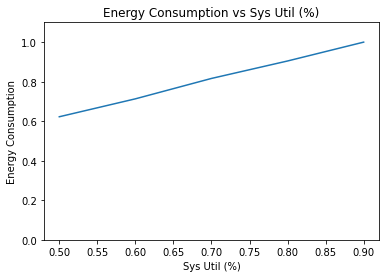

In [8]:
# 4. Plot graph

plt.plot(sys_utils, results_norm)
plt.title('Energy Consumption vs Sys Util (%)')
plt.xlabel('Sys Util (%)')
plt.ylabel('Energy Consumption')

plt.ylim([0.0, 1.1])

plt.show()

### b. Analysing impact of frequency of HP Core

The backup core can be scaled . This affects energy consumption, and the active duration of the HP Core.

In [36]:
# scheduler parameters
k = 20
sys_util = 0.5  # fixed at 50% system utilisation
lp_hp_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations
active_duration_results = []

# 2. Run algorithms
for spd_ratio in lp_hp_ratios:
    energy_consumed_per_sysutil = 0
    active_duration_per_spdratio = 0
    for i in range(num_sets):
        # i. import task set
        with open('tasksets/sysutil{0}_{1}.csv'.format(sys_util, i)) as read_obj:
            # pass the file object to reader() to get the reader object
            csv_reader = reader(read_obj)
            # Get all rows of csv from csv_reader object as list of tuples
            tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

        # ii. convert data into Task objects
        tasks = []
        for task in tasks_data:
            # Adjust HP core execution time based on new LP:HP speed ratio
            hp_execTime = round(task[1] * spd_ratio, precision_dp)
            tasks.append(Task(task[0], task[1], hp_execTime))

        # iii. run the FEST algorithm
        energy_consumed = 0
        active_duration = 0
        for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
            system = System(k, frame_duration, time_step, spd_ratio)
            system.run(tasks)
            # get total energy consumption
            energy = system.get_energy_consumption()
            
            # get HP core active duration
            duration = system.get_hpcore_active_duration()
            
            energy_consumed += energy
            active_duration += duration
        energy_consumed /= repeat  # get the average from the repeated runs
        active_duration /= repeat
        
        # iv. get energy consumption data point from this task set
        energy_consumed_per_sysutil += energy_consumed
        active_duration_per_spdratio += active_duration
    
    # v. get the average energy consumption for this sys_util value over different task sets
    energy_consumed_per_sysutil /= num_sets
    active_duration_per_spdratio /= num_sets
    
    energy_consumed_results.append(energy_consumed_per_sysutil)
    active_duration_results.append(active_duration_per_spdratio)
    
print("Done")
print(energy_consumed_results)
print(active_duration_results)

Done
[1168.4805800000006, 314.7881360000001, 170.60497955555564, 111.84121200000007, 88.93963200000006, 75.0823167407408, 66.4896883381925, 61.34712425000007, 57.66403283950624, 55.03600400000006]
[1.1252000000000006, 2.1708000000000007, 3.4332000000000003, 4.371200000000001, 5.6808000000000005, 6.802, 7.830000000000001, 9.010000000000002, 10.1376, 11.206000000000001]


In [40]:
# 3. Normalize energy consumption
import numpy as np
results_norm = np.array(energy_consumed_results) / max(energy_consumed_results)

print(results_norm)

[1.         0.26939954 0.14600583 0.09571508 0.07611563 0.06425637
 0.05690269 0.05250162 0.04934959 0.04710049]


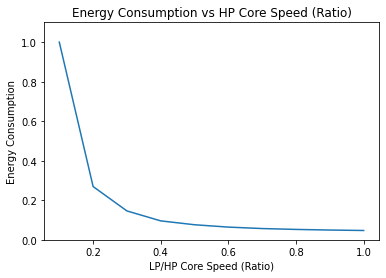

In [42]:
# 4. Plot graph

plt.plot(lp_hp_ratios, results_norm)
plt.title('Energy Consumption vs HP Core Speed (Ratio)')
plt.xlabel('LP/HP Core Speed (Ratio)')
plt.ylabel('Energy Consumption')

plt.ylim([0.0, 1.1])

plt.show()

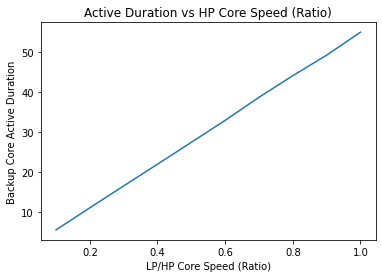

In [31]:
# Plot Backup Core Active Duration vs LP/HP Core Speed

plt.plot(lp_hp_ratios, active_duration_results)
plt.title('Active Duration vs HP Core Speed (Ratio)')
plt.xlabel('LP/HP Core Speed (Ratio)')
plt.ylabel('Backup Core Active Duration')

plt.show()

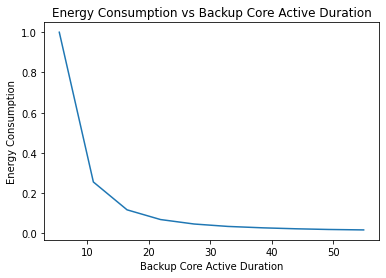

In [32]:
# Plot Energy Consumption vs Backup Core Active Duration

plt.plot(active_duration_results, results_norm)
plt.title('Energy Consumption vs Backup Core Active Duration')
plt.xlabel('Backup Core Active Duration')
plt.ylabel('Energy Consumption')

plt.show()

### c. Energy Consumption vs No. Faults, k

In [ ]:
# scheduler parameters
k_values = [20, 40, 60, 80, 100, 120, 140, 160]
sys_util = 0.5  # fixed at 50% system utilisation

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations

# 2. Run algorithms
for k in k_values:
    energy_consumed_per_sysutil = 0
    for i in range(num_sets):
        # i. import task set
        with open('tasksets/sysutil{0}_{1}.csv'.format(sys_util, i)) as read_obj:
            # pass the file object to reader() to get the reader object
            csv_reader = reader(read_obj)
            # Get all rows of csv from csv_reader object as list of tuples
            tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

        # ii. convert data into Task objects
        tasks = []
        for task in tasks_data:
            tasks.append(Task(task[0], task[1], task[2]))

        # iii. run the FEST algorithm
        energy_consumed = 0
        for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
            system = System(k, frame_duration, time_step, lp_hp_ratio)
            system.run(tasks)
            # get total energy consumption
            energy = system.get_energy_consumption()
            
            energy_consumed += energy
        energy_consumed /= repeat  # get the average from the repeated runs
        
        # iv. get energy consumption data point from this task set
        energy_consumed_per_sysutil += energy_consumed
    
    # v. get the average energy consumption for this sys_util value over different task sets
    energy_consumed_per_sysutil /= num_sets
    
    energy_consumed_results.append(energy_consumed_per_sysutil)
    
print("Done")
print(energy_consumed_results)

In [ ]:
# 3. Normalize energy consumption
import numpy as np
results_norm = np.array(energy_consumed_results) / max(energy_consumed_results)

print(results_norm)

In [ ]:
# 4. Plot graph

plt.plot(k_values, results_norm)
plt.title('Energy Consumption vs Sys Util (%)')
plt.xlabel('No. Faults (k)')
plt.ylabel('Energy Consumption')

plt.ylim([0.0, 1.1])

plt.show()

### d. Distribution of Faults

If the distribution of the fault occurrences were not uniform